# <font color='#2C3333'>CLTV Prediction with BG-NBD and Gamma-Gamma</font>

### <font color='#362FD9'>Business Problem</font>

##### <font color='#2C3333'>FLO wants to set a roadmap for sales and marketing activities. In order for the company to make a medium-long-term plan.<br><br> It's necessary to estimate the potential value that existing customers will provide to the company in the future.
</font>

### <font color='#362FD9'>Story of the Dataset</font>

##### <font color='#2C3333'>The dataset consists of information obtained from the past shopping behaviors of customers who made their last shopping both online and offline in 2020-2021.
</font>

### <font color='#362FD9'>Imports</font>

In [63]:
import pandas as pd
import datetime as dt
import seaborn as sns
# !pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### <font color='#362FD9'>Reading Csv File</font>

In [2]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


### <font color='#362FD9'>Information About the Dataset</font>

In [3]:
def info(dataframe):
    print("****************- COLUMNS -*********************\n")
    print(dataframe.columns)
    print("\n***********- TYPES OF VARIABLES -***********\n")
    print(dataframe.dtypes)
    print("\n***********- MISSING VALUES -************\n")
    print(dataframe.isnull().sum())
    print("\n******************- INFORMATION -********************\n")
    print(dataframe.info())
    print("\n****************- DESCRIPTIVE STATISTICS -****************\n")
    print(dataframe.describe().T)
    
info(df)  

****************- COLUMNS -*********************

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date',
       'last_order_date', 'last_order_date_online', 'last_order_date_offline',
       'order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'interested_in_categories_12'],
      dtype='object')

***********- TYPES OF VARIABLES -***********

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           o

### <font color='#362FD9'>Outlier Detection</font>

In [13]:
# Defining the outlier_thresholds and replace_with_thresholds functions needed to suppress outliers.
# Note: When calculating cltv, frequency values must be integers. Therefore, round the lower and upper limits with round().
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [14]:
# Applying to float columns
columns = ["order_num_total_ever_online", "order_num_total_ever_offline",
           "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

In [15]:
# Creating new columns for total number of orders and total money paid by customers.
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [16]:
# Changing the type of variables that express dates.
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [17]:
# I set 2 days after the last purchase in the dataset as the analysis date.
df["last_order_date"].max()  # 2021-05-30
analysis_date = dt.datetime(2021, 6, 1)

In [18]:
# Creating the CLTV Data Structure
# Creating a new cltv dataframe with customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg values.
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"] - df["first_order_date"]).astype('timedelta64[D]')) / 7
cltv_df["T_weekly"] = ((analysis_date - df["first_order_date"]).astype('timedelta64[D]')) / 7
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

In [19]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


### <font color='#362FD9'>Creating BG/NBD and Gamma-Gamma Models, calculation of 6-month CLTV</font>

In [20]:
# BG/NBD => Expected Number of Transaction
# Gamma-Gamma => Expected Average Profit

In [21]:
# BG/NBD fit model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [22]:
# Prediction of expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe.
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

In [23]:
# Prediction of expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe.
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

In [24]:
# Review the 10 people who will make the most purchases in the 3rd and 6th months.

In [25]:
# 3 Months
cltv_df.sort_values("exp_sales_3_month",ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


In [26]:
# 6 Months
cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


In [27]:
# Fit the Gamma-Gamma model. Estimate the average value of the customers and add it to the cltv dataframe as exp_average_value.
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33


In [28]:
# Calculate 6 months CLTV and add it to the dataframe with the name cltv.
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv

In [29]:
# Review the 10 people with the highest CLTV.
cltv_df.sort_values("cltv",ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1.09,2.19,1449.06,3327.78
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,1.97,3.94,767.36,3172.39
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,0.72,1.44,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,1.57,3.13,506.17,1662.61
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31,166.71,1628.89
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,1.27,2.53,611.49,1623.81
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,0.79,1.59,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,0.87,1.74,778.05,1423.00


In [30]:
# Divide all your customers into 4 groups (segments) according to the 6-month standardized CLTV
# and add the group names to the dataset. Assign it with the name cltv_segment.
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63,395.73,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67,199.43,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97,170.22,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32,98.95,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33,95.01,D


In [60]:
# Statistics of Segments
cltv_df.groupby("cltv_segment").agg({"cltv": ["count", "mean", "std", "median"]})

cltv                     
             count   mean    std median
cltv_segment                           
D             4987  80.34  21.73  83.72
C             4986 138.31  15.32 138.03
B             4986 199.53  21.21 198.10
A             4986 362.32 158.42 312.93

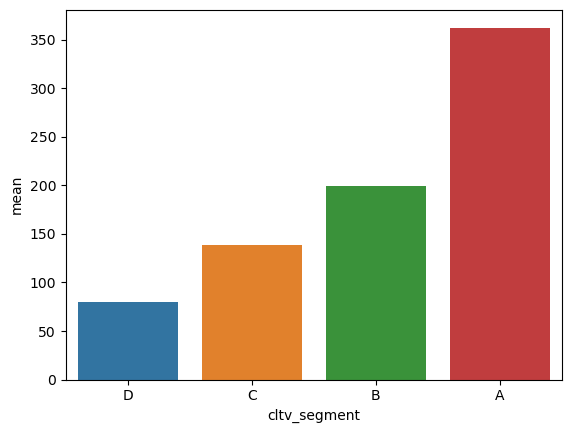

In [61]:
# Barplot
means = cltv_df.groupby("cltv_segment").agg({"cltv": ["mean"]})
means.columns = means.columns.get_level_values(1)
sns.barplot(x=means.index, y=means["mean"]);